# TensorFlow GAN for Anime Face Generation

## Overview

This script demonstrates the construction and training of a Generative Adversarial Network (GAN) using TensorFlow. The GAN consists of two main components: a Generator and a Discriminator. The goal is to generate anime faces by training the network with a dataset of anime images. The generator creates new images from random noise, while the discriminator evaluates their authenticity.

---

### Section 1: Importing Necessary Libraries


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Section 2: Function for Loading and Processing Images

Defines a function `load_imgs` to load and preprocess a set of images. This function reads images from a specified path, converts them to a uniform size and format, and stores them as normalized NumPy arrays. It limits the number of images loaded to 20,000.


In [2]:
def load_imgs(impath):
    imgs=[]
    l1=os.listdir(impath)
    for i in l1:
        if len(imgs)==3000:
           break
        c=0
        img=Image.open(impath+'/'+i).convert('RGB')
        img=img.resize(size=(256,256))
        img=np.array(img,dtype=np.float16)/255
        imgs.append(np.array(img)) 
        del img
    imgs=np.array(imgs)
    return imgs

### Section 3: Creating the Training Dataset

Loads and prepares the anime images as a TensorFlow dataset. This dataset is shuffled and batched to facilitate efficient training of the GAN.


In [3]:
train_images = load_imgs('/kaggle/input/another-anime-face-dataset/animefaces256cleaner')
train_images.shape

(3000, 256, 256, 3)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(32)
len(train_dataset)

94

### Section 4: Defining the Generator and Discriminator Models


Outlines the architecture of both the Generator and Discriminator models using TensorFlow's Keras API. These models are designed to work together within the GAN framework, where the Generator creates images and the Discriminator evaluates them.


In [5]:
def generator_model():
    model = models.Sequential()
    model.add(layers.Dense(64 * 64 * 256, input_shape=(100,), activation='relu'))
    model.add(layers.Reshape((64, 64, 256)))
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', activation='tanh'))
    return model

# Discriminator model
def discriminator_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(256, 256, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


generator = generator_model()
discriminator = discriminator_model()

### Section 5: Loss Functions and Optimizers

Defines the loss functions for the generator and discriminator, crucial for their training and interaction. Also sets up the Adam optimizer for both models, which is a popular choice for training neural networks.


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define the optimizer for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



### Section 6: Training Procedure

Establishes the training loop for the GAN. It includes a function to execute a training step on a batch of images and a loop to run through multiple epochs of training, progressively improving the Generator and Discriminator.


In [7]:
# Define the training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([32, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

                                                    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
for epoch in range(200):
    for image_batch in train_dataset:
        train_step(image_batch)
    print(f'Epoch {epoch+1} completed')

/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-13 06:40:16.660205: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-13 06:41:22.763174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed
Epoch 51 completed
Epoch 52 completed
Epoch 53 completed
Ep

### Section 7: Generating and Visualizing New Images

After training, this section uses the generator model to create new anime faces. These generated images are then visualized using Matplotlib to showcase the capabilities of the trained Generator.


In [10]:
noise = tf.random.normal([32, 100])
generated=generator(noise)

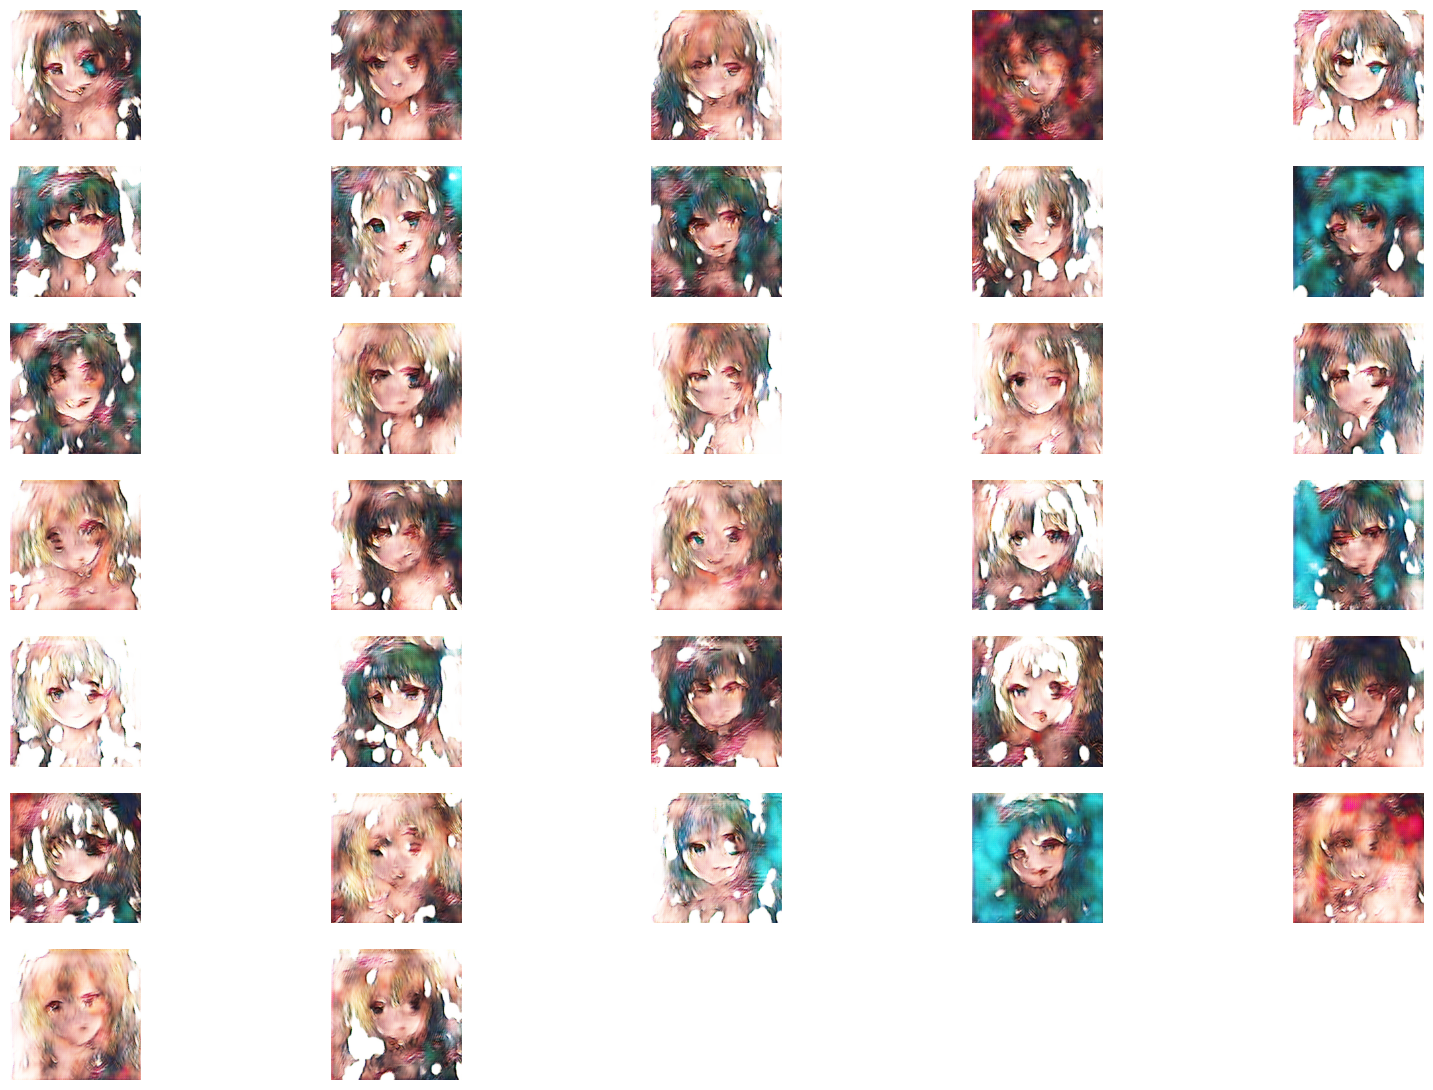

In [11]:
fig = plt.figure(figsize=(20,20))
rows = 10
columns = 5

for i in range(0,32):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(generated[i])
    plt.axis('off')